In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import time

from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import ast
import os
import pickle
import json


from pprint import pprint

import sys 
sys.path.insert(1, "../")
from workloads.util import use_results, use_dataset, read_config, log_dataset, join_queries_features
from workloads.recsys.recsys_util import get_features, get_feature_update, predict_rating

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
dataset_dir = use_dataset("ml-latest-small")
results_dir = use_results("ml-latest-small")
#experiment = "results_workers_user_32_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001"

experiment = "results_workers_user_8_key-fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001"

/data/wooders/ralf-vldb//datasets/ml-latest-small


In [252]:
os.listdir(results_dir)

['results_workers_user_8_key-fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001.csv',
 'results_workers_user_8_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.01.csv',
 'results_workers_user_32_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001.csv',
 'results_workers_user_2_ml_learningrate_0.02_userfeaturereg_0.01_sleep_0.001.csv',
 'results_workers_user_1_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.1.csv',
 'results_workers_user_2_key-fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001.csv',
 'results_workers_sgd_1_fifo-100_learningrate_0.02_userfeaturereg_0.01_sleep_0.1.csv',
 'results_workers_user_8_ml_learningrate_0.02_userfeaturereg_0.01_sleep_0.001.csv',
 'results_workers_user_2_fifo_learningrate_0.02_userfeaturereg_0.01_sleep_0.001.csv']

## Read Experiment Results

In [253]:
events_df = pd.read_csv(f'{dataset_dir}/test.csv')

In [254]:
results_df = pd.read_csv(f'{results_dir}/{experiment}.csv')

In [255]:
results_df

,user_id,user_features,ingest_time,timestamp,processing_time,runtime
0,45,"[0.08245328466150217, 0.008904671218049132, 0....",1.646036e+09,81,1.646036e+09,1.145397
1,560,"[0.20233865831717093, -0.029339719772595127, 0...",1.646036e+09,81,1.646036e+09,1.150074
2,186,"[0.31641403891609465, 0.0849392233123104, 0.24...",1.646036e+09,81,1.646036e+09,1.159948
3,606,"[0.1601744159527951, 0.0663623686514915, 0.092...",1.646036e+09,81,1.646036e+09,1.191342
4,509,"[0.19047495304806558, 0.03279256996016002, 0.2...",1.646036e+09,81,1.646036e+09,1.353814
...,...,...,...,...,...,...
397,11,"[0.07070043303577314, 0.0413310835546713, 0.22...",1.646036e+09,9550,1.646036e+09,0.319520
398,83,"[0.11000680195199285, 0.028487495547892882, 0....",1.646036e+09,9560,1.646036e+09,0.321991
399,434,"[0.14315080982718673, 0.03433480437678938, -0....",1.646036e+09,9741,1.646036e+09,0.325144
400,199,"[0.18987475543202093, 0.062453356234686445, 0....",1.646036e+09,9534,1.646036e+09,0.328234


## Read Dataset 

In [256]:
movie_to_index = json.load(open(f"{dataset_dir}/movie_to_index.json", "r"))
user_to_index = json.load(open(f"{dataset_dir}/user_to_index.json", "r"))
user_matrix = pickle.load(open(f"{dataset_dir}/user_matrix.pkl", "rb"))
movie_matrix = pickle.load(open(f"{dataset_dir}/movie_matrix.pkl", "rb"))
A = pickle.load(open(f"{dataset_dir}/A.pkl", "rb"))
R = pickle.load(open(f"{dataset_dir}/R.pkl", "rb"))

## Evaluate Experiment Features 

In [257]:
def updated_embedding(df, ui): 
    
    # calculate embedding from dataframe of updates form a single user

    ui = user_to_index[str(ui)]
    streaming_user_matrix = np.array(user_matrix, copy=True) 
    A_matrix = np.array(A, copy=True)
    R_matrix = np.array(R, copy=True)
    user_feature_reg = 10

    for index, row in df.iterrows():
        ui = user_to_index[str(int(row["user_id"]))]
        mi = movie_to_index[str(int(row["movie_id"]))]
        A_matrix[ui][mi] = row["rating"]
        R_matrix[ui][mi] = 1
        
    Ri = R_matrix[ui]
    n_factors = len(user_matrix[ui])

    return np.linalg.solve(
        np.dot(movie_matrix.T, np.dot(np.diag(Ri), movie_matrix)) + user_feature_reg * np.eye(n_factors),
        np.dot(movie_matrix.T, np.dot(np.diag(Ri), A_matrix[ui].T))
    ).T

In [262]:
# map real timestamps 

ts_to_time = {}

for index, row in results_df.iterrows(): 
    if row["timestamp"] not in ts_to_time: 
        ts_to_time[row["timestamp"]] = row["ingest_time"]

In [301]:
cache = {}

In [302]:
def evaluate_user(user, ts):
    
    # oracle feature 
    user_df = events_df[(events_df["user_id"] == user) & (events_df["timestamp"] < ts)]
    
    if f"{user}_{ts}" in cache: 
        oracle_feature = cache[f"{user}_{ts}"]
    else:
        oracle_feature = updated_embedding(user_df, user).tolist()
        cache[f"{user}_{ts}"] = oracle_feature
    
    # actual feature 
    update_df = results_df[(results_df["user_id"] == user) & (results_df["processing_time"] < ts_to_time[ts])]
    update_ts = update_df.timestamp.max() 
    processed_df = events_df[(events_df["user_id"] == user) & (events_df["timestamp"] <= update_ts)]
    if len(update_df.index) == 0:
        #print("no updates", user, ts)
        return None
    
    feature = ast.literal_eval(update_df.user_features.tolist()[-1])
    
    # metrics 
    staleness = user_df.timestamp.max()  - update_df.timestamp.max() 
    past_updates = len(processed_df.index)
    pending_updates = len(user_df.index) - past_updates
    
    
    # loss between features 
    feature_loss = mean_squared_error(oracle_feature, feature)
    
    # loss between predictions with features (better metric)
    oracle_pred = [np.dot(np.array(oracle_feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]
    pred = [np.dot(np.array(feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]
    prediction_loss = mean_squared_error(oracle_pred, pred)
    
    return {"ts": ts, "user": user, "feature_loss": feature_loss, "prediction_loss": prediction_loss, "staleness": staleness, "past_updates": past_updates, "pending_updates": pending_updates}

In [303]:
from tqdm import tqdm 

In [304]:
data = []

In [308]:
for ts in tqdm(list(ts_to_time.keys())[72:]): #[3239, 3237, 4519, 10045, 10662]: # randomly selected timestamps to evaluate at 
    for user in events_df.user_id.value_counts().index.tolist()[:10]: #set(results_df.user_id.tolist()):
        
        d = evaluate_user(user, ts)
        if d is not None: data.append(d)

100%|██████████| 314/314 [20:14<00:00,  3.87s/it]


In [309]:
data_df = pd.DataFrame(data)

In [310]:
data_df

,ts,user,feature_loss,prediction_loss,staleness,past_updates,pending_updates
0,1442,606,0.003785,0.177856,1322,2,170
1,625,606,0.000011,0.000053,3,2,6
2,623,606,0.000011,0.000053,3,2,6
3,607,606,0.000011,0.000053,3,2,6
4,1442,606,0.003785,0.177856,1322,2,170
...,...,...,...,...,...,...,...
1775,9533,448,0.000000,0.000000,0,125,0
1776,9533,380,0.000000,0.000000,0,351,0
1777,9533,387,0.000000,0.000000,0,412,0
1778,9533,606,0.000077,0.000309,1408,507,7


# Attempt to Model Loss

<AxesSubplot:xlabel='ts'>

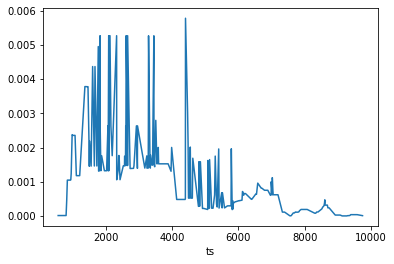

In [311]:
data_df.groupby("ts").feature_loss.mean().plot()

<AxesSubplot:xlabel='ts'>

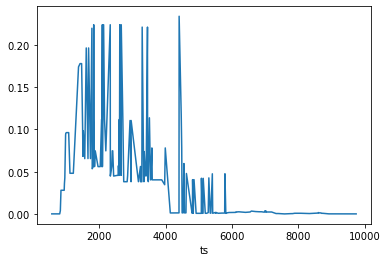

In [312]:
data_df.groupby("ts").prediction_loss.mean().plot()

<AxesSubplot:>

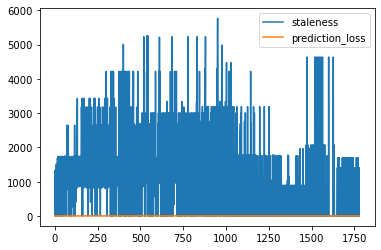

In [313]:
data_df[["staleness", "prediction_loss"]].plot()

<AxesSubplot:>

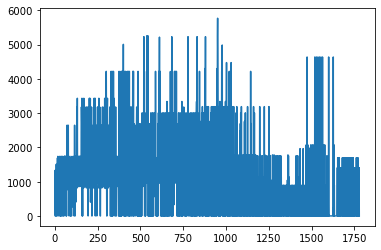

In [314]:
data_df.staleness.plot()

In [ ]:
from sklearn.model_selection import train_test_split

In [315]:
from sklearn.metrics import mean_squared_error

In [316]:
mean_squared_error(oracle_feature, feature)

0.0007864545900573374

In [325]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [330]:
x = data_df[["staleness", "past_updates", "pending_updates"]].to_numpy()
y = data_df["prediction_loss"].to_numpy()

In [326]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [327]:
regr = RandomForestRegressor(random_state=0)
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [328]:
train_err = mean_squared_error(regr.predict(X_train), y_train)
print(train_err)
test_err = mean_squared_error(regr.predict(X_test), y_test)
print(test_err)

1.1604296106327372e-05
8.089973981076744e-05


In [335]:
pickle.dump(regr, open(f"{dataset_dir}/random_forest_model", "wb"))

In [331]:
clf = SGDRegressor().fit(X_train, y_train)

In [332]:
train_err = mean_squared_error(clf.predict(X_train), y_train)
print(train_err)
test_err = mean_squared_error(clf.predict(X_test), y_test)
print(test_err)

1.0662132552659519e+29
1.0047951994562867e+29


In [284]:
clf.predict()

TypeError: predict() missing 1 required positional argument: 'X'

In [285]:
x = data_df[["staleness", "past_updates"]].to_numpy()
y = data_df["prediction_loss"].to_numpy()

clf = SGDRegressor().fit(x, y)
train_err = mean_squared_error(clf.predict(x), y)
train_err

4.7943274590540256e+26

In [225]:
x = data_df[["staleness"]].to_numpy()
y = data_df["prediction_loss"].to_numpy()

#clf = SGDRegressor(loss="huber").fit(x, y)
clf = SGDRegressor(loss="huber").fit(x, y)
train_err = mean_squared_error(clf.predict(x), y)
train_err

0.003199790139035662

In [333]:
train_err = mean_squared_error([y.mean()]*y.shape[0], y)
train_err

0.0025845530474632207

In [78]:
oracle_pred = [np.dot(np.array(oracle_feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]
pred = [np.dot(np.array(feature), movie_matrix[mid]) for mid in range(movie_matrix.shape[0])]

In [79]:
mean_squared_error(oracle_pred, pred)

0.026040872747266245

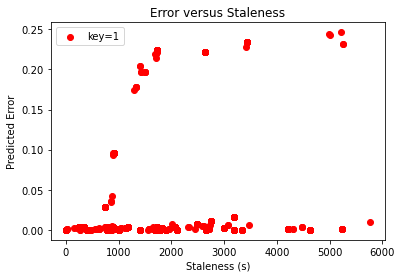

In [338]:
import matplotlib.pyplot as plt

plt.scatter(data_df["staleness"].tolist(), data_df["prediction_loss"].tolist(), c ="red", label=f"key={key}")

plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

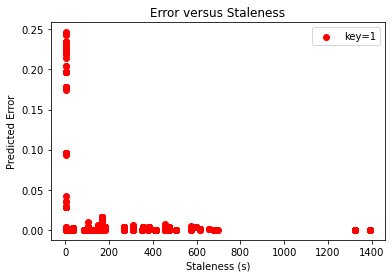

In [339]:
plt.scatter(data_df["past_updates"].tolist(), data_df["prediction_loss"].tolist(), c ="red", label=f"key={key}")

plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()

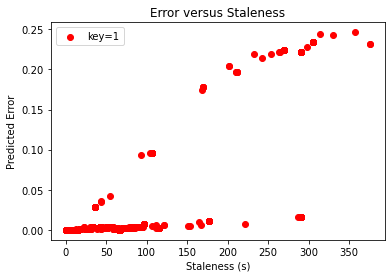

In [340]:
plt.scatter(data_df["pending_updates"].tolist(), data_df["prediction_loss"].tolist(), c ="red", label=f"key={key}")

plt.legend()
# To show the plot
plt.title("Error versus Staleness")
plt.ylabel("Predicted Error")
plt.xlabel("Staleness (s)")
plt.show()